In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../../data_in/CE_Crateus.csv'
data_output_path = '../../data_out/weather.csv'
data_output_path_npsave = '../../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

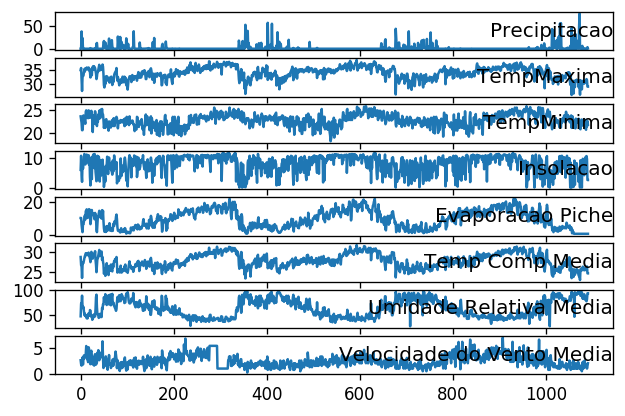

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler.inverse_transform(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
        
    return [y_hats, y_tests]

In [18]:
def metrics(y_hats, y_tests):
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    percentual = 100
    n = len(y_hats)
    j = 1
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_max[i] - y_tests_max[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1
    
    print('\nMinimum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))
    
    j = 1
    percentual = 100
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_min[i] - y_tests_min[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1

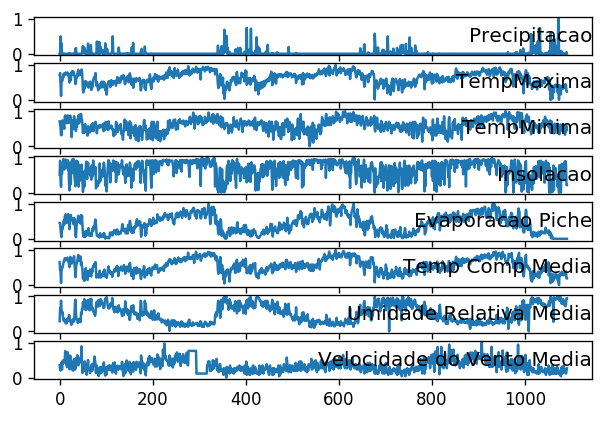

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2314 - mean_squared_error: 0.0828 - val_loss: 0.2283 - val_mean_squared_error: 0.0599
Epoch 2/1000
 - 1s - loss: 0.1440 - mean_squared_error: 0.0326 - val_loss: 0.1470 - val_mean_squared_error: 0.0395
Epoch 3/1000
 - 1s - loss: 0.1325 - mean_squared_error: 0.0288 - val_loss: 0.1640 - val_mean_squared_error: 0.0414
Epoch 4/1000
 - 1s - loss: 0.1250 - mean_squared_error: 0.0257 - val_loss: 0.1638 - val_mean_squared_error: 0.0483
Epoch 5/1000
 - 1s - loss: 0.1162 - mean_squared_error: 0.0229 - val_loss: 0.1561 - val_mean_squared_error: 0.0400
Epoch 6/1000
 - 1s - loss: 0.1118 - mean_squared_error: 0.0211 - val_loss: 0.1470 - val_mean_squared_error: 0.0352
Epoch 7/1000
 - 1s - loss: 0.1124 - mean_squared_error: 0.0210 - val_loss: 0.1495 - val_mean_squared_error: 0.0385
Epoch 8/1000
 - 1s - loss: 0.1066 - mean_squared_error: 0.0191 - val_loss: 0.1469 - val_mean_squared_error: 0.0401
Epoch 9/1000
 - 1s - loss: 0.1049 -

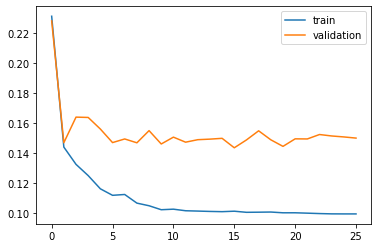


predict: [[35.67880419 33.12187349]]
real:      [[18.09923077 31.95789474]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3849 - mean_squared_error: 0.1945 - val_loss: 0.1867 - val_mean_squared_error: 0.0694
Epoch 2/1000
 - 1s - loss: 0.1615 - mean_squared_error: 0.0430 - val_loss: 0.1006 - val_mean_squared_error: 0.0105
Epoch 3/1000
 - 1s - loss: 0.1407 - mean_squared_error: 0.0317 - val_loss: 0.1473 - val_mean_squared_error: 0.0218
Epoch 4/1000
 - 1s - loss: 0.1332 - mean_squared_error: 0.0284 - val_loss: 0.1445 - val_mean_squared_error: 0.0209
Epoch 5/1000
 - 1s - loss: 0.1281 - mean_squared_error: 0.0264 - val_loss: 0.1365 - val_mean_squared_error: 0.0189
Epoch 6/1000
 - 1s - loss: 0.1221 - mean_squared_error: 0.0238 - val_loss: 0.1048 - val_mean_squared_error: 0.0129
Epoch 7/1000
 - 1s - loss: 0.1160 - mean_squared_error: 0.0220 - val_loss: 0.0977 - val_mean_squared_error: 0.0099
Epoch 8/1000
 - 1s - loss: 0.1135 - mean_squared_error: 0.0210 - val_los

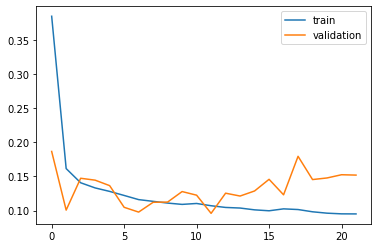


predict: [[36.37765925 33.32501398]]
real:      [[18.09923077 33.32631579]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2654 - mean_squared_error: 0.1107 - val_loss: 0.0766 - val_mean_squared_error: 0.0113
Epoch 2/1000
 - 1s - loss: 0.1467 - mean_squared_error: 0.0332 - val_loss: 0.1075 - val_mean_squared_error: 0.0128
Epoch 3/1000
 - 1s - loss: 0.1348 - mean_squared_error: 0.0301 - val_loss: 0.0773 - val_mean_squared_error: 0.0066
Epoch 4/1000
 - 1s - loss: 0.1252 - mean_squared_error: 0.0257 - val_loss: 0.0586 - val_mean_squared_error: 0.0039
Epoch 5/1000
 - 1s - loss: 0.1115 - mean_squared_error: 0.0208 - val_loss: 0.0688 - val_mean_squared_error: 0.0066
Epoch 6/1000
 - 1s - loss: 0.1176 - mean_squared_error: 0.0226 - val_loss: 0.0694 - val_mean_squared_error: 0.0049
Epoch 7/1000
 - 1s - loss: 0.1103 - mean_squared_error: 0.0197 - val_loss: 0.0774 - val_mean_squared_error: 0.0080
Epoch 8/1000
 - 1s - loss: 0.1062 - mean_squared_error: 0.0190 - val_los

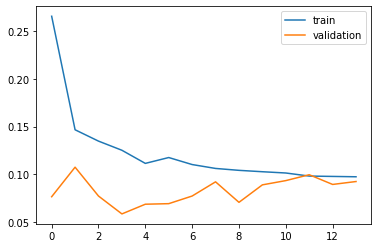


predict: [[37.6210605 33.4095528]]
real:      [[32.11153846 31.27368421]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2637 - mean_squared_error: 0.1109 - val_loss: 0.2915 - val_mean_squared_error: 0.0908
Epoch 2/1000
 - 1s - loss: 0.1500 - mean_squared_error: 0.0355 - val_loss: 0.2010 - val_mean_squared_error: 0.0455
Epoch 3/1000
 - 1s - loss: 0.1347 - mean_squared_error: 0.0285 - val_loss: 0.2375 - val_mean_squared_error: 0.0610
Epoch 4/1000
 - 1s - loss: 0.1268 - mean_squared_error: 0.0256 - val_loss: 0.2234 - val_mean_squared_error: 0.0540
Epoch 5/1000
 - 1s - loss: 0.1188 - mean_squared_error: 0.0230 - val_loss: 0.2177 - val_mean_squared_error: 0.0552
Epoch 6/1000
 - 1s - loss: 0.1118 - mean_squared_error: 0.0204 - val_loss: 0.1900 - val_mean_squared_error: 0.0430
Epoch 7/1000
 - 1s - loss: 0.1098 - mean_squared_error: 0.0196 - val_loss: 0.2328 - val_mean_squared_error: 0.0595
Epoch 8/1000
 - 1s - loss: 0.1076 - mean_squared_error: 0.0192 - val_loss:

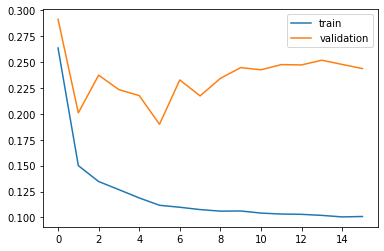


predict: [[36.42012823 33.78526478]]
real:      [[34.44692308 33.66842105]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2868 - mean_squared_error: 0.1228 - val_loss: 0.2121 - val_mean_squared_error: 0.0456
Epoch 2/1000
 - 1s - loss: 0.1459 - mean_squared_error: 0.0339 - val_loss: 0.1421 - val_mean_squared_error: 0.0250
Epoch 3/1000
 - 1s - loss: 0.1324 - mean_squared_error: 0.0274 - val_loss: 0.1732 - val_mean_squared_error: 0.0340
Epoch 4/1000
 - 1s - loss: 0.1262 - mean_squared_error: 0.0253 - val_loss: 0.1837 - val_mean_squared_error: 0.0363
Epoch 5/1000
 - 1s - loss: 0.1190 - mean_squared_error: 0.0227 - val_loss: 0.1734 - val_mean_squared_error: 0.0318
Epoch 6/1000
 - 1s - loss: 0.1146 - mean_squared_error: 0.0213 - val_loss: 0.1465 - val_mean_squared_error: 0.0231
Epoch 7/1000
 - 1s - loss: 0.1104 - mean_squared_error: 0.0201 - val_loss: 0.1499 - val_mean_squared_error: 0.0236
Epoch 8/1000
 - 1s - loss: 0.1084 - mean_squared_error: 0.0196 - val_los

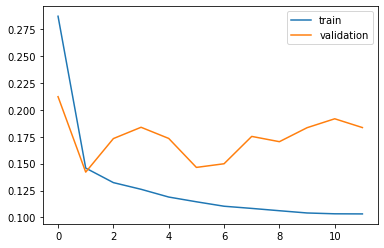


predict: [[32.23611373 33.79202466]]
real:      [[30.36       30.07631579]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3256 - mean_squared_error: 0.1589 - val_loss: 0.2492 - val_mean_squared_error: 0.0675
Epoch 2/1000
 - 1s - loss: 0.1513 - mean_squared_error: 0.0361 - val_loss: 0.0948 - val_mean_squared_error: 0.0094
Epoch 3/1000
 - 1s - loss: 0.1353 - mean_squared_error: 0.0291 - val_loss: 0.1572 - val_mean_squared_error: 0.0251
Epoch 4/1000
 - 1s - loss: 0.1311 - mean_squared_error: 0.0270 - val_loss: 0.1547 - val_mean_squared_error: 0.0242
Epoch 5/1000
 - 1s - loss: 0.1261 - mean_squared_error: 0.0252 - val_loss: 0.1675 - val_mean_squared_error: 0.0281
Epoch 6/1000
 - 1s - loss: 0.1218 - mean_squared_error: 0.0237 - val_loss: 0.1766 - val_mean_squared_error: 0.0312
Epoch 7/1000
 - 1s - loss: 0.1151 - mean_squared_error: 0.0216 - val_loss: 0.1640 - val_mean_squared_error: 0.0270
Epoch 8/1000
 - 1s - loss: 0.1129 - mean_squared_error: 0.0211 - val_los

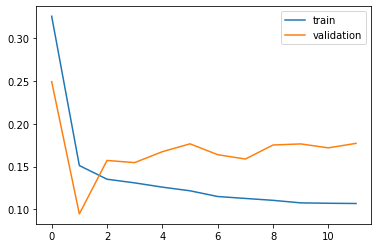


predict: [[34.59355267 32.33008085]]
real:      [[28.60846154 30.41842105]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2791 - mean_squared_error: 0.1142 - val_loss: 0.2091 - val_mean_squared_error: 0.0558
Epoch 2/1000
 - 1s - loss: 0.1529 - mean_squared_error: 0.0370 - val_loss: 0.0868 - val_mean_squared_error: 0.0143
Epoch 3/1000
 - 1s - loss: 0.1391 - mean_squared_error: 0.0303 - val_loss: 0.1210 - val_mean_squared_error: 0.0202
Epoch 4/1000
 - 1s - loss: 0.1340 - mean_squared_error: 0.0283 - val_loss: 0.1411 - val_mean_squared_error: 0.0241
Epoch 5/1000
 - 1s - loss: 0.1293 - mean_squared_error: 0.0264 - val_loss: 0.1503 - val_mean_squared_error: 0.0279
Epoch 6/1000
 - 1s - loss: 0.1233 - mean_squared_error: 0.0243 - val_loss: 0.1208 - val_mean_squared_error: 0.0204
Epoch 7/1000
 - 1s - loss: 0.1148 - mean_squared_error: 0.0213 - val_loss: 0.1258 - val_mean_squared_error: 0.0244
Epoch 8/1000
 - 1s - loss: 0.1099 - mean_squared_error: 0.0200 - val_los

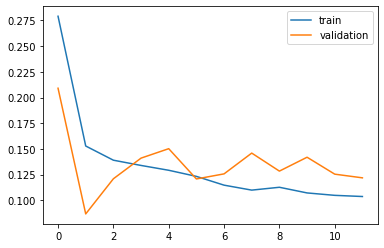


predict: [[33.90652559 32.87146031]]
real:      [[28.02461538 31.61578947]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4808 - mean_squared_error: 0.2895 - val_loss: 0.4129 - val_mean_squared_error: 0.1996
Epoch 2/1000
 - 1s - loss: 0.1973 - mean_squared_error: 0.0681 - val_loss: 0.1715 - val_mean_squared_error: 0.0443
Epoch 3/1000
 - 1s - loss: 0.1404 - mean_squared_error: 0.0325 - val_loss: 0.1661 - val_mean_squared_error: 0.0317
Epoch 4/1000
 - 1s - loss: 0.1353 - mean_squared_error: 0.0302 - val_loss: 0.1306 - val_mean_squared_error: 0.0247
Epoch 5/1000
 - 1s - loss: 0.1323 - mean_squared_error: 0.0285 - val_loss: 0.1253 - val_mean_squared_error: 0.0195
Epoch 6/1000
 - 1s - loss: 0.1323 - mean_squared_error: 0.0283 - val_loss: 0.1254 - val_mean_squared_error: 0.0264
Epoch 7/1000
 - 1s - loss: 0.1294 - mean_squared_error: 0.0278 - val_loss: 0.1410 - val_mean_squared_error: 0.0264
Epoch 8/1000
 - 1s - loss: 0.1270 - mean_squared_error: 0.0267 - val_los

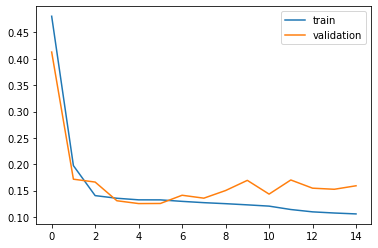


predict: [[31.30295205 32.94818621]]
real:      [[26.27307692 32.64210526]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4703 - mean_squared_error: 0.2655 - val_loss: 0.2367 - val_mean_squared_error: 0.0777
Epoch 2/1000
 - 1s - loss: 0.1859 - mean_squared_error: 0.0553 - val_loss: 0.0951 - val_mean_squared_error: 0.0090
Epoch 3/1000
 - 1s - loss: 0.1438 - mean_squared_error: 0.0321 - val_loss: 0.1109 - val_mean_squared_error: 0.0161
Epoch 4/1000
 - 1s - loss: 0.1365 - mean_squared_error: 0.0296 - val_loss: 0.0888 - val_mean_squared_error: 0.0136
Epoch 5/1000
 - 1s - loss: 0.1312 - mean_squared_error: 0.0274 - val_loss: 0.0805 - val_mean_squared_error: 0.0115
Epoch 6/1000
 - 1s - loss: 0.1254 - mean_squared_error: 0.0253 - val_loss: 0.0698 - val_mean_squared_error: 0.0088
Epoch 7/1000
 - 1s - loss: 0.1186 - mean_squared_error: 0.0227 - val_loss: 0.0878 - val_mean_squared_error: 0.0134
Epoch 8/1000
 - 1s - loss: 0.1084 - mean_squared_error: 0.0197 - val_los

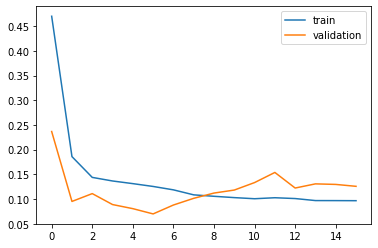


predict: [[35.51766184 33.00370728]]
real:      [[24.52153846 34.01052632]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5668 - mean_squared_error: 0.3694 - val_loss: 0.2063 - val_mean_squared_error: 0.0432
Epoch 2/1000
 - 1s - loss: 0.2128 - mean_squared_error: 0.0717 - val_loss: 0.1908 - val_mean_squared_error: 0.0464
Epoch 3/1000
 - 1s - loss: 0.1417 - mean_squared_error: 0.0317 - val_loss: 0.0865 - val_mean_squared_error: 0.0086
Epoch 4/1000
 - 1s - loss: 0.1371 - mean_squared_error: 0.0294 - val_loss: 0.1321 - val_mean_squared_error: 0.0208
Epoch 5/1000
 - 1s - loss: 0.1329 - mean_squared_error: 0.0279 - val_loss: 0.1288 - val_mean_squared_error: 0.0179
Epoch 6/1000
 - 1s - loss: 0.1294 - mean_squared_error: 0.0267 - val_loss: 0.1188 - val_mean_squared_error: 0.0143
Epoch 7/1000
 - 1s - loss: 0.1286 - mean_squared_error: 0.0263 - val_loss: 0.1444 - val_mean_squared_error: 0.0210
Epoch 8/1000
 - 1s - loss: 0.1219 - mean_squared_error: 0.0240 - val_los

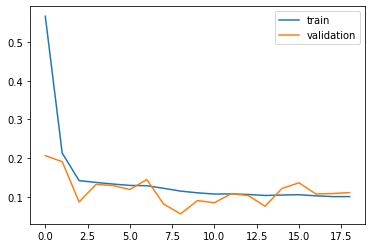


predict: [[35.66203828 32.58659219]]
real:      [[30.94384615 33.49736842]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3327 - mean_squared_error: 0.1574 - val_loss: 0.1390 - val_mean_squared_error: 0.0374
Epoch 2/1000
 - 1s - loss: 0.1649 - mean_squared_error: 0.0437 - val_loss: 0.0734 - val_mean_squared_error: 0.0059
Epoch 3/1000
 - 1s - loss: 0.1474 - mean_squared_error: 0.0343 - val_loss: 0.0868 - val_mean_squared_error: 0.0146
Epoch 4/1000
 - 1s - loss: 0.1382 - mean_squared_error: 0.0300 - val_loss: 0.0713 - val_mean_squared_error: 0.0092
Epoch 5/1000
 - 1s - loss: 0.1306 - mean_squared_error: 0.0269 - val_loss: 0.0801 - val_mean_squared_error: 0.0126
Epoch 6/1000
 - 1s - loss: 0.1191 - mean_squared_error: 0.0229 - val_loss: 0.1235 - val_mean_squared_error: 0.0173
Epoch 7/1000
 - 1s - loss: 0.1100 - mean_squared_error: 0.0198 - val_loss: 0.1202 - val_mean_squared_error: 0.0176
Epoch 8/1000
 - 1s - loss: 0.1083 - mean_squared_error: 0.0197 - val_los

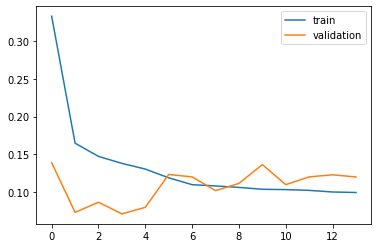


predict: [[35.39604787 33.41866516]]
real:      [[30.94384615 32.64210526]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3097 - mean_squared_error: 0.1409 - val_loss: 0.1482 - val_mean_squared_error: 0.0236
Epoch 2/1000
 - 1s - loss: 0.1546 - mean_squared_error: 0.0378 - val_loss: 0.1498 - val_mean_squared_error: 0.0254
Epoch 3/1000
 - 1s - loss: 0.1379 - mean_squared_error: 0.0310 - val_loss: 0.1785 - val_mean_squared_error: 0.0347
Epoch 4/1000
 - 1s - loss: 0.1361 - mean_squared_error: 0.0300 - val_loss: 0.1649 - val_mean_squared_error: 0.0274
Epoch 5/1000
 - 1s - loss: 0.1250 - mean_squared_error: 0.0250 - val_loss: 0.1876 - val_mean_squared_error: 0.0368
Epoch 6/1000
 - 1s - loss: 0.1151 - mean_squared_error: 0.0220 - val_loss: 0.2019 - val_mean_squared_error: 0.0410
Epoch 7/1000
 - 1s - loss: 0.1114 - mean_squared_error: 0.0212 - val_loss: 0.1456 - val_mean_squared_error: 0.0215
Epoch 8/1000
 - 1s - loss: 0.1102 - mean_squared_error: 0.0199 - val_los

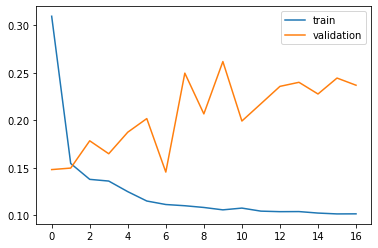


predict: [[26.53310088 32.15489151]]
real:      [[30.36       33.49736842]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3855 - mean_squared_error: 0.2028 - val_loss: 0.2553 - val_mean_squared_error: 0.0856
Epoch 2/1000
 - 1s - loss: 0.1586 - mean_squared_error: 0.0424 - val_loss: 0.2732 - val_mean_squared_error: 0.0989
Epoch 3/1000
 - 1s - loss: 0.1396 - mean_squared_error: 0.0311 - val_loss: 0.2044 - val_mean_squared_error: 0.0632
Epoch 4/1000
 - 1s - loss: 0.1327 - mean_squared_error: 0.0283 - val_loss: 0.2205 - val_mean_squared_error: 0.0796
Epoch 5/1000
 - 1s - loss: 0.1240 - mean_squared_error: 0.0253 - val_loss: 0.2107 - val_mean_squared_error: 0.0739
Epoch 6/1000
 - 1s - loss: 0.1194 - mean_squared_error: 0.0236 - val_loss: 0.2051 - val_mean_squared_error: 0.0735
Epoch 7/1000
 - 1s - loss: 0.1152 - mean_squared_error: 0.0221 - val_loss: 0.2125 - val_mean_squared_error: 0.0879
Epoch 8/1000
 - 1s - loss: 0.1106 - mean_squared_error: 0.0205 - val_los

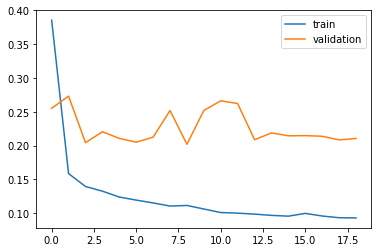


predict: [[25.73581505 31.70864205]]
real:      [[28.60846154 31.61578947]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3355 - mean_squared_error: 0.1669 - val_loss: 0.2447 - val_mean_squared_error: 0.0879
Epoch 2/1000
 - 1s - loss: 0.1534 - mean_squared_error: 0.0377 - val_loss: 0.1534 - val_mean_squared_error: 0.0287
Epoch 3/1000
 - 1s - loss: 0.1354 - mean_squared_error: 0.0289 - val_loss: 0.1454 - val_mean_squared_error: 0.0410
Epoch 4/1000
 - 1s - loss: 0.1309 - mean_squared_error: 0.0270 - val_loss: 0.1322 - val_mean_squared_error: 0.0349
Epoch 5/1000
 - 1s - loss: 0.1266 - mean_squared_error: 0.0256 - val_loss: 0.1383 - val_mean_squared_error: 0.0352
Epoch 6/1000
 - 1s - loss: 0.1217 - mean_squared_error: 0.0243 - val_loss: 0.1662 - val_mean_squared_error: 0.0431
Epoch 7/1000
 - 1s - loss: 0.1185 - mean_squared_error: 0.0230 - val_loss: 0.1651 - val_mean_squared_error: 0.0446
Epoch 8/1000
 - 1s - loss: 0.1154 - mean_squared_error: 0.0221 - val_los

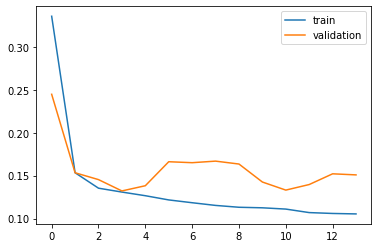


predict: [[37.59823922 33.39584939]]
real:      [[12.26076923 33.83947368]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5385 - mean_squared_error: 0.3308 - val_loss: 0.1423 - val_mean_squared_error: 0.0247
Epoch 2/1000
 - 1s - loss: 0.1977 - mean_squared_error: 0.0613 - val_loss: 0.2312 - val_mean_squared_error: 0.0539
Epoch 3/1000
 - 1s - loss: 0.1440 - mean_squared_error: 0.0320 - val_loss: 0.2149 - val_mean_squared_error: 0.0472
Epoch 4/1000
 - 1s - loss: 0.1372 - mean_squared_error: 0.0294 - val_loss: 0.1518 - val_mean_squared_error: 0.0250
Epoch 5/1000
 - 1s - loss: 0.1348 - mean_squared_error: 0.0286 - val_loss: 0.1704 - val_mean_squared_error: 0.0293
Epoch 6/1000
 - 1s - loss: 0.1305 - mean_squared_error: 0.0269 - val_loss: 0.1746 - val_mean_squared_error: 0.0306
Epoch 7/1000
 - 1s - loss: 0.1290 - mean_squared_error: 0.0265 - val_loss: 0.1784 - val_mean_squared_error: 0.0320
Epoch 8/1000
 - 1s - loss: 0.1278 - mean_squared_error: 0.0260 - val_los

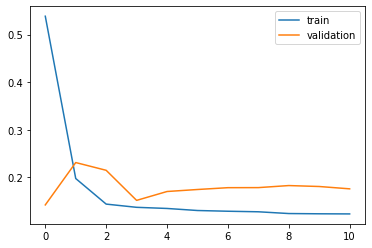


predict: [[21.48931517 28.67706202]]
real:      [[21.60230769 33.83947368]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4993 - mean_squared_error: 0.3008 - val_loss: 0.0277 - val_mean_squared_error: 8.2289e-04
Epoch 2/1000
 - 1s - loss: 0.1729 - mean_squared_error: 0.0468 - val_loss: 0.2169 - val_mean_squared_error: 0.0470
Epoch 3/1000
 - 1s - loss: 0.1496 - mean_squared_error: 0.0342 - val_loss: 0.2438 - val_mean_squared_error: 0.0628
Epoch 4/1000
 - 1s - loss: 0.1388 - mean_squared_error: 0.0305 - val_loss: 0.2111 - val_mean_squared_error: 0.0460
Epoch 5/1000
 - 1s - loss: 0.1346 - mean_squared_error: 0.0285 - val_loss: 0.2170 - val_mean_squared_error: 0.0487
Epoch 6/1000
 - 1s - loss: 0.1340 - mean_squared_error: 0.0281 - val_loss: 0.1987 - val_mean_squared_error: 0.0418
Epoch 7/1000
 - 1s - loss: 0.1322 - mean_squared_error: 0.0275 - val_loss: 0.2151 - val_mean_squared_error: 0.0488
Epoch 8/1000
 - 1s - loss: 0.1313 - mean_squared_error: 0.0273 - val

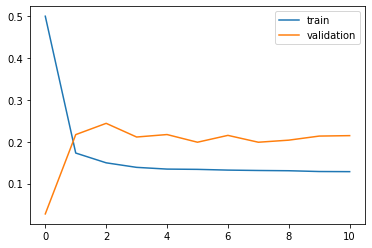


predict: [[30.21630262 29.22263541]]
real:      [[28.60846154 31.78684211]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3555 - mean_squared_error: 0.1853 - val_loss: 0.3217 - val_mean_squared_error: 0.1591
Epoch 2/1000
 - 1s - loss: 0.1566 - mean_squared_error: 0.0401 - val_loss: 0.3797 - val_mean_squared_error: 0.1830
Epoch 3/1000
 - 1s - loss: 0.1403 - mean_squared_error: 0.0314 - val_loss: 0.3753 - val_mean_squared_error: 0.1654
Epoch 4/1000
 - 1s - loss: 0.1340 - mean_squared_error: 0.0291 - val_loss: 0.3784 - val_mean_squared_error: 0.1726
Epoch 5/1000
 - 1s - loss: 0.1284 - mean_squared_error: 0.0266 - val_loss: 0.3611 - val_mean_squared_error: 0.1569
Epoch 6/1000
 - 1s - loss: 0.1248 - mean_squared_error: 0.0249 - val_loss: 0.3711 - val_mean_squared_error: 0.1545
Epoch 7/1000
 - 1s - loss: 0.1160 - mean_squared_error: 0.0223 - val_loss: 0.3737 - val_mean_squared_error: 0.1615
Epoch 8/1000
 - 1s - loss: 0.1143 - mean_squared_error: 0.0221 - val_los

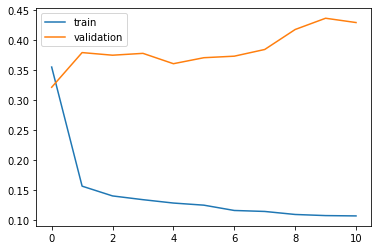


predict: [[35.45751536 30.93221723]]
real:      [[32.11153846 30.24736842]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4437 - mean_squared_error: 0.2773 - val_loss: 0.0962 - val_mean_squared_error: 0.0093
Epoch 2/1000
 - 1s - loss: 0.1651 - mean_squared_error: 0.0429 - val_loss: 0.2740 - val_mean_squared_error: 0.0827
Epoch 3/1000
 - 1s - loss: 0.1420 - mean_squared_error: 0.0310 - val_loss: 0.3079 - val_mean_squared_error: 0.0998
Epoch 4/1000
 - 1s - loss: 0.1371 - mean_squared_error: 0.0295 - val_loss: 0.2482 - val_mean_squared_error: 0.0639
Epoch 5/1000
 - 1s - loss: 0.1311 - mean_squared_error: 0.0270 - val_loss: 0.2728 - val_mean_squared_error: 0.0774
Epoch 6/1000
 - 1s - loss: 0.1236 - mean_squared_error: 0.0245 - val_loss: 0.2707 - val_mean_squared_error: 0.0738
Epoch 7/1000
 - 1s - loss: 0.1159 - mean_squared_error: 0.0219 - val_loss: 0.2297 - val_mean_squared_error: 0.0610
Epoch 8/1000
 - 1s - loss: 0.1154 - mean_squared_error: 0.0220 - val_los

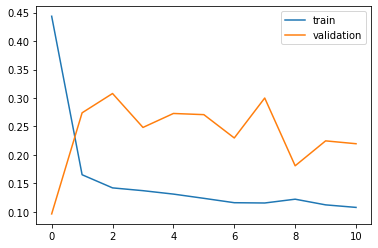


predict: [[23.26073873 32.06448661]]
real:      [[ 0.58384615 30.76052632]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4039 - mean_squared_error: 0.2135 - val_loss: 0.1605 - val_mean_squared_error: 0.0397
Epoch 2/1000
 - 1s - loss: 0.1627 - mean_squared_error: 0.0429 - val_loss: 0.1250 - val_mean_squared_error: 0.0166
Epoch 3/1000
 - 1s - loss: 0.1391 - mean_squared_error: 0.0301 - val_loss: 0.1814 - val_mean_squared_error: 0.0329
Epoch 4/1000
 - 1s - loss: 0.1346 - mean_squared_error: 0.0286 - val_loss: 0.1583 - val_mean_squared_error: 0.0251
Epoch 5/1000
 - 1s - loss: 0.1317 - mean_squared_error: 0.0275 - val_loss: 0.1634 - val_mean_squared_error: 0.0270
Epoch 6/1000
 - 1s - loss: 0.1316 - mean_squared_error: 0.0274 - val_loss: 0.1734 - val_mean_squared_error: 0.0325
Epoch 7/1000
 - 1s - loss: 0.1297 - mean_squared_error: 0.0268 - val_loss: 0.1716 - val_mean_squared_error: 0.0295
Epoch 8/1000
 - 1s - loss: 0.1249 - mean_squared_error: 0.0249 - val_los

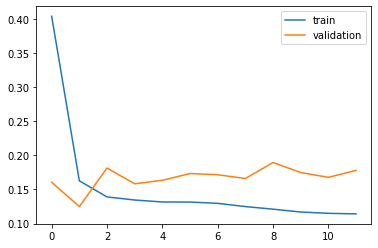


predict: [[39.75837554 32.11251672]]
real:      [[19.85076923 30.58947368]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.2349 - mean_squared_error: 0.0897 - val_loss: 0.2493 - val_mean_squared_error: 0.0678
Epoch 2/1000
 - 1s - loss: 0.1566 - mean_squared_error: 0.0381 - val_loss: 0.2080 - val_mean_squared_error: 0.0785
Epoch 3/1000
 - 1s - loss: 0.1438 - mean_squared_error: 0.0335 - val_loss: 0.1975 - val_mean_squared_error: 0.0533
Epoch 4/1000
 - 1s - loss: 0.1338 - mean_squared_error: 0.0290 - val_loss: 0.1983 - val_mean_squared_error: 0.0551
Epoch 5/1000
 - 1s - loss: 0.1287 - mean_squared_error: 0.0267 - val_loss: 0.2010 - val_mean_squared_error: 0.0628
Epoch 6/1000
 - 1s - loss: 0.1269 - mean_squared_error: 0.0257 - val_loss: 0.1995 - val_mean_squared_error: 0.0677
Epoch 7/1000
 - 1s - loss: 0.1149 - mean_squared_error: 0.0217 - val_loss: 0.2076 - val_mean_squared_error: 0.0645
Epoch 8/1000
 - 1s - loss: 0.1140 - mean_squared_error: 0.0215 - val_los

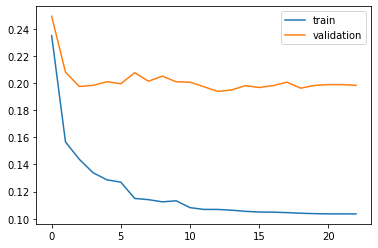


predict: [[30.13588186 32.425305  ]]
real:      [[30.94384615 31.61578947]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.2774 - mean_squared_error: 0.1198 - val_loss: 0.1049 - val_mean_squared_error: 0.0213
Epoch 2/1000
 - 1s - loss: 0.1597 - mean_squared_error: 0.0395 - val_loss: 0.0764 - val_mean_squared_error: 0.0080
Epoch 3/1000
 - 1s - loss: 0.1454 - mean_squared_error: 0.0328 - val_loss: 0.0861 - val_mean_squared_error: 0.0098
Epoch 4/1000
 - 1s - loss: 0.1370 - mean_squared_error: 0.0291 - val_loss: 0.0987 - val_mean_squared_error: 0.0104
Epoch 5/1000
 - 1s - loss: 0.1326 - mean_squared_error: 0.0280 - val_loss: 0.0639 - val_mean_squared_error: 0.0067
Epoch 6/1000
 - 1s - loss: 0.1308 - mean_squared_error: 0.0270 - val_loss: 0.0760 - val_mean_squared_error: 0.0067
Epoch 7/1000
 - 1s - loss: 0.1220 - mean_squared_error: 0.0242 - val_loss: 0.1223 - val_mean_squared_error: 0.0170
Epoch 8/1000
 - 1s - loss: 0.1173 - mean_squared_error: 0.0225 - val_los

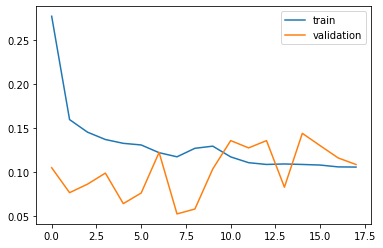


predict: [[31.38911149 33.15787737]]
real:      [[16.93153846 34.18157895]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3438 - mean_squared_error: 0.1640 - val_loss: 0.0566 - val_mean_squared_error: 0.0038
Epoch 2/1000
 - 1s - loss: 0.1651 - mean_squared_error: 0.0432 - val_loss: 0.1481 - val_mean_squared_error: 0.0342
Epoch 3/1000
 - 1s - loss: 0.1416 - mean_squared_error: 0.0319 - val_loss: 0.1400 - val_mean_squared_error: 0.0241
Epoch 4/1000
 - 1s - loss: 0.1337 - mean_squared_error: 0.0281 - val_loss: 0.1256 - val_mean_squared_error: 0.0187
Epoch 5/1000
 - 1s - loss: 0.1282 - mean_squared_error: 0.0264 - val_loss: 0.1296 - val_mean_squared_error: 0.0220
Epoch 6/1000
 - 1s - loss: 0.1224 - mean_squared_error: 0.0246 - val_loss: 0.1893 - val_mean_squared_error: 0.0367
Epoch 7/1000
 - 1s - loss: 0.1159 - mean_squared_error: 0.0221 - val_loss: 0.1061 - val_mean_squared_error: 0.0138
Epoch 8/1000
 - 1s - loss: 0.1119 - mean_squared_error: 0.0206 - val_los

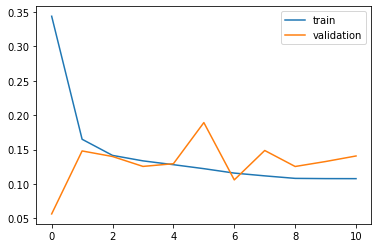


predict: [[23.34519036 31.94185256]]
real:      [[31.52769231 32.64210526]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5913 - mean_squared_error: 0.3974 - val_loss: 0.3479 - val_mean_squared_error: 0.1295
Epoch 2/1000
 - 1s - loss: 0.3492 - mean_squared_error: 0.1782 - val_loss: 0.0937 - val_mean_squared_error: 0.0088
Epoch 3/1000
 - 1s - loss: 0.1838 - mean_squared_error: 0.0532 - val_loss: 0.1300 - val_mean_squared_error: 0.0228
Epoch 4/1000
 - 1s - loss: 0.1393 - mean_squared_error: 0.0312 - val_loss: 0.1177 - val_mean_squared_error: 0.0272
Epoch 5/1000
 - 1s - loss: 0.1331 - mean_squared_error: 0.0287 - val_loss: 0.1222 - val_mean_squared_error: 0.0216
Epoch 6/1000
 - 1s - loss: 0.1291 - mean_squared_error: 0.0274 - val_loss: 0.1390 - val_mean_squared_error: 0.0352
Epoch 7/1000
 - 1s - loss: 0.1229 - mean_squared_error: 0.0253 - val_loss: 0.1244 - val_mean_squared_error: 0.0211
Epoch 8/1000
 - 1s - loss: 0.1123 - mean_squared_error: 0.0209 - val_los

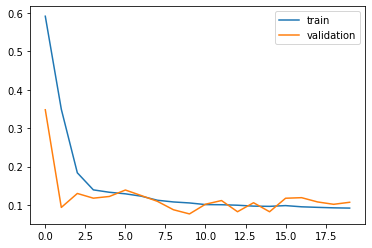


predict: [[28.61993946 33.21017425]]
real:      [[30.94384615 32.64210526]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3834 - mean_squared_error: 0.2013 - val_loss: 0.0911 - val_mean_squared_error: 0.0119
Epoch 2/1000
 - 1s - loss: 0.1586 - mean_squared_error: 0.0395 - val_loss: 0.0821 - val_mean_squared_error: 0.0069
Epoch 3/1000
 - 1s - loss: 0.1404 - mean_squared_error: 0.0303 - val_loss: 0.0793 - val_mean_squared_error: 0.0091
Epoch 4/1000
 - 1s - loss: 0.1348 - mean_squared_error: 0.0281 - val_loss: 0.0634 - val_mean_squared_error: 0.0069
Epoch 5/1000
 - 1s - loss: 0.1316 - mean_squared_error: 0.0270 - val_loss: 0.0795 - val_mean_squared_error: 0.0089
Epoch 6/1000
 - 1s - loss: 0.1294 - mean_squared_error: 0.0263 - val_loss: 0.0570 - val_mean_squared_error: 0.0058
Epoch 7/1000
 - 1s - loss: 0.1260 - mean_squared_error: 0.0252 - val_loss: 0.0674 - val_mean_squared_error: 0.0067
Epoch 8/1000
 - 1s - loss: 0.1210 - mean_squared_error: 0.0234 - val_los

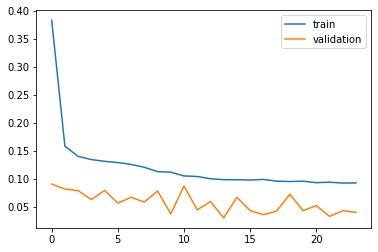


predict: [[32.65339323 33.0529698 ]]
real:      [[30.36       33.49736842]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4364 - mean_squared_error: 0.2556 - val_loss: 0.3956 - val_mean_squared_error: 0.1566
Epoch 2/1000
 - 1s - loss: 0.2191 - mean_squared_error: 0.0711 - val_loss: 0.1849 - val_mean_squared_error: 0.0354
Epoch 3/1000
 - 1s - loss: 0.1400 - mean_squared_error: 0.0317 - val_loss: 0.0914 - val_mean_squared_error: 0.0151
Epoch 4/1000
 - 1s - loss: 0.1327 - mean_squared_error: 0.0283 - val_loss: 0.1065 - val_mean_squared_error: 0.0173
Epoch 5/1000
 - 1s - loss: 0.1258 - mean_squared_error: 0.0258 - val_loss: 0.0820 - val_mean_squared_error: 0.0103
Epoch 6/1000
 - 1s - loss: 0.1180 - mean_squared_error: 0.0227 - val_loss: 0.0848 - val_mean_squared_error: 0.0135
Epoch 7/1000
 - 1s - loss: 0.1103 - mean_squared_error: 0.0204 - val_loss: 0.0841 - val_mean_squared_error: 0.0087
Epoch 8/1000
 - 1s - loss: 0.1084 - mean_squared_error: 0.0193 - val_los

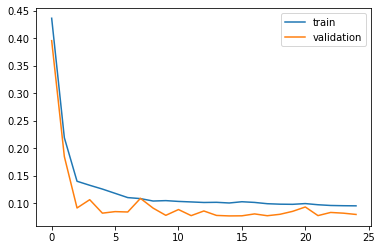


predict: [[26.7442537  30.78754266]]
real:      [[33.27923077 33.83947368]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.2499 - mean_squared_error: 0.0965 - val_loss: 0.1218 - val_mean_squared_error: 0.0152
Epoch 2/1000
 - 1s - loss: 0.1491 - mean_squared_error: 0.0352 - val_loss: 0.0766 - val_mean_squared_error: 0.0068
Epoch 3/1000
 - 1s - loss: 0.1344 - mean_squared_error: 0.0285 - val_loss: 0.0968 - val_mean_squared_error: 0.0096
Epoch 4/1000
 - 1s - loss: 0.1230 - mean_squared_error: 0.0242 - val_loss: 0.1047 - val_mean_squared_error: 0.0110
Epoch 5/1000
 - 1s - loss: 0.1148 - mean_squared_error: 0.0218 - val_loss: 0.1053 - val_mean_squared_error: 0.0114
Epoch 6/1000
 - 1s - loss: 0.1111 - mean_squared_error: 0.0204 - val_loss: 0.1028 - val_mean_squared_error: 0.0106
Epoch 7/1000
 - 1s - loss: 0.1077 - mean_squared_error: 0.0192 - val_loss: 0.0947 - val_mean_squared_error: 0.0093
Epoch 8/1000
 - 1s - loss: 0.1049 - mean_squared_error: 0.0184 - val_los

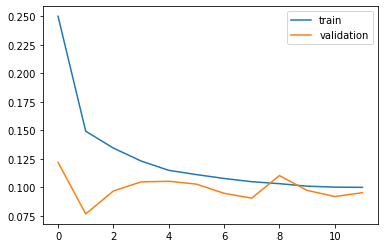


predict: [[35.60357698 33.495997  ]]
real:      [[29.77615385 33.66842105]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5537 - mean_squared_error: 0.3586 - val_loss: 0.1425 - val_mean_squared_error: 0.0229
Epoch 2/1000
 - 1s - loss: 0.2051 - mean_squared_error: 0.0669 - val_loss: 0.1948 - val_mean_squared_error: 0.0569
Epoch 3/1000
 - 1s - loss: 0.1532 - mean_squared_error: 0.0370 - val_loss: 0.1631 - val_mean_squared_error: 0.0266
Epoch 4/1000
 - 1s - loss: 0.1407 - mean_squared_error: 0.0315 - val_loss: 0.1972 - val_mean_squared_error: 0.0416
Epoch 5/1000
 - 1s - loss: 0.1354 - mean_squared_error: 0.0293 - val_loss: 0.2014 - val_mean_squared_error: 0.0415
Epoch 6/1000
 - 1s - loss: 0.1319 - mean_squared_error: 0.0278 - val_loss: 0.1968 - val_mean_squared_error: 0.0405
Epoch 7/1000
 - 1s - loss: 0.1277 - mean_squared_error: 0.0262 - val_loss: 0.1966 - val_mean_squared_error: 0.0417
Epoch 8/1000
 - 1s - loss: 0.1211 - mean_squared_error: 0.0239 - val_los

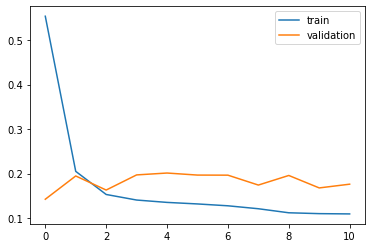


predict: [[18.18376275 27.8429595 ]]
real:      [[31.52769231 34.18157895]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3126 - mean_squared_error: 0.1411 - val_loss: 0.2399 - val_mean_squared_error: 0.0841
Epoch 2/1000
 - 1s - loss: 0.1547 - mean_squared_error: 0.0391 - val_loss: 0.2153 - val_mean_squared_error: 0.0619
Epoch 3/1000
 - 1s - loss: 0.1382 - mean_squared_error: 0.0304 - val_loss: 0.1601 - val_mean_squared_error: 0.0440
Epoch 4/1000
 - 1s - loss: 0.1270 - mean_squared_error: 0.0263 - val_loss: 0.1580 - val_mean_squared_error: 0.0464
Epoch 5/1000
 - 1s - loss: 0.1179 - mean_squared_error: 0.0227 - val_loss: 0.1360 - val_mean_squared_error: 0.0354
Epoch 6/1000
 - 1s - loss: 0.1121 - mean_squared_error: 0.0204 - val_loss: 0.1525 - val_mean_squared_error: 0.0463
Epoch 7/1000
 - 1s - loss: 0.1122 - mean_squared_error: 0.0206 - val_loss: 0.1534 - val_mean_squared_error: 0.0389
Epoch 8/1000
 - 1s - loss: 0.1078 - mean_squared_error: 0.0193 - val_los

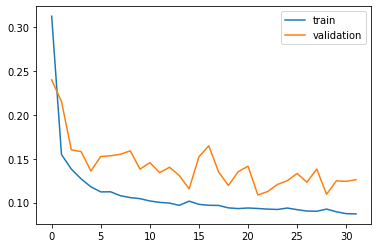


predict: [[30.556016   32.37456481]]
real:      [[30.36       30.58947368]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3029 - mean_squared_error: 0.1363 - val_loss: 0.1670 - val_mean_squared_error: 0.0439
Epoch 2/1000
 - 1s - loss: 0.1594 - mean_squared_error: 0.0404 - val_loss: 0.0696 - val_mean_squared_error: 0.0083
Epoch 3/1000
 - 1s - loss: 0.1329 - mean_squared_error: 0.0282 - val_loss: 0.1068 - val_mean_squared_error: 0.0225
Epoch 4/1000
 - 1s - loss: 0.1264 - mean_squared_error: 0.0253 - val_loss: 0.1577 - val_mean_squared_error: 0.0345
Epoch 5/1000
 - 1s - loss: 0.1221 - mean_squared_error: 0.0241 - val_loss: 0.1425 - val_mean_squared_error: 0.0298
Epoch 6/1000
 - 1s - loss: 0.1180 - mean_squared_error: 0.0225 - val_loss: 0.1152 - val_mean_squared_error: 0.0260
Epoch 7/1000
 - 1s - loss: 0.1160 - mean_squared_error: 0.0217 - val_loss: 0.1378 - val_mean_squared_error: 0.0300
Epoch 8/1000
 - 1s - loss: 0.1128 - mean_squared_error: 0.0206 - val_los

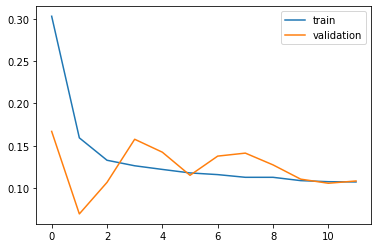


predict: [[26.72391157 33.27051418]]
real:      [[16.93153846 33.49736842]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 0.3742 - mean_squared_error: 0.2038 - val_loss: 0.2211 - val_mean_squared_error: 0.0501
Epoch 2/1000
 - 1s - loss: 0.1618 - mean_squared_error: 0.0425 - val_loss: 0.0405 - val_mean_squared_error: 0.0016
Epoch 3/1000
 - 1s - loss: 0.1418 - mean_squared_error: 0.0311 - val_loss: 0.1643 - val_mean_squared_error: 0.0275
Epoch 4/1000
 - 1s - loss: 0.1330 - mean_squared_error: 0.0276 - val_loss: 0.1341 - val_mean_squared_error: 0.0180
Epoch 5/1000
 - 1s - loss: 0.1262 - mean_squared_error: 0.0255 - val_loss: 0.1331 - val_mean_squared_error: 0.0177
Epoch 6/1000
 - 1s - loss: 0.1210 - mean_squared_error: 0.0236 - val_loss: 0.1447 - val_mean_squared_error: 0.0213
Epoch 7/1000
 - 1s - loss: 0.1146 - mean_squared_error: 0.0214 - val_loss: 0.1530 - val_mean_squared_error: 0.0235
Epoch 8/1000
 - 1s - loss: 0.1114 - mean_squared_error: 0.0202 - val_los

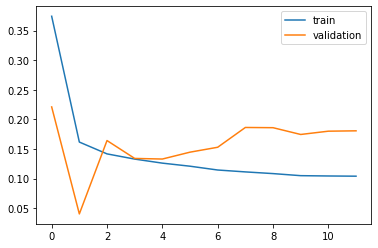


predict: [[26.61594423 32.05395277]]
real:      [[25.10538462 33.66842105]]



In [12]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

min_max_scaler = preprocessing.MinMaxScaler()
values_scaled = min_max_scaler.fit_transform(values)
dataset_scaled = DataFrame(values_scaled)
dataset_scaled.index = dataset.index
dataset_scaled.columns = dataset.columns

plot_columns(values_scaled)

result = NCV(dataset_scaled, days_to_predict, min_max_scaler)

In [19]:
y_hats = result[0]
y_tests = result[1]

metrics(y_hats, y_tests)

Maximum metrics
Test RMSE -------------------------- 10.28
Test VARIANCE ---------------------- -0.453
Test MAX-ERROR --------------------- 25.34
Test MEAN-ABSOLUTE-ERROR ----------- 7.575
Test MEDIAN-ABSOLUTE-ERROR --------- 5.27

Accuracy
10.0% of predictions missed 1 point(s) or less
13.33% of predictions missed 2 point(s) or less
10.0% of predictions missed 3 point(s) or less
6.67% of predictions missed 4 point(s) or less
6.67% of predictions missed 5 point(s) or less
16.67% of predictions missed 6 point(s) or less
3.33% of predictions missed 7 point(s) or less

Minimum metrics
Test RMSE -------------------------- 2.044
Test VARIANCE ---------------------- -1.361
Test MAX-ERROR --------------------- 6.339
Test MEAN-ABSOLUTE-ERROR ----------- 1.438
Test MEDIAN-ABSOLUTE-ERROR --------- 1.015

Accuracy
46.67% of predictions missed 1 point(s) or less
33.33% of predictions missed 2 point(s) or less
6.67% of predictions missed 3 point(s) or less
6.67% of predictions missed 4 point(s) or 